Suraj Khetarpal
CS-E109 Final Project Process Book

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import os
os.chdir("C:\\Users\\maryfraw\\Desktop\\CS109\\Final Project")
import sklearn
import sklearn.neighbors
from sklearn import cross_validation
import seaborn as sns
import random
import sklearn.tree
from sklearn import svm

## Overview and Motivation

I am very interested in artificial intelligence and its application to medicine and medical research.  I am also excited by the possibility of using machine learning to develop tools that will help people to better understand the human brain.  Hopefully, by better understanding how the brain learns, we will be able to develop better machine learning methodologies (and vice versa). Research in this area can be used to better understand how the brain processes information and how it learns.  For example, if we have good prediction models for brain activity, we can use this to determine when a baby monkey's brain is starting to recognize different types of visual stimuli.  This could help us to understand how a baby monkey's brain develops in the first place.  The possible benefits from this are limitless.

This is why I have decided to make this project about regression analysis and machine learning using fMTI brain scan data.  I will be using fMRI scans that were taken while monkeys were shown different types of visual stimuli.  These experiments were done on monkeys rather than humans for legal reasons.  Using the results of the scans, I will use regression analysis and machine learning to develop a classifier that can accurately predict a visual stimulus based on a monkey's fMRI brain activity.

I would like this project to include:
1. A program to read in fMRI experimentation data, convert it into a usable format, perform data wrangling, and create concise data structures that are suitable for my analysis.
2. A regression analysis to create beta value data points to be used in the machine learning algorithms.
3. The application of a machine learning algorithm that achieves above a 90% accuracy score.
4. An analysis of the successes and failures of multiple classifiers.
5) Visual Aids

## Related Work

I recently started volunteering at a a nuerobiology research lab at the Harvard Medical School. This has given me access to fMRI monkey brain scan data.

I learned a great deal about different machine learning techniques in CS-E109, and I intend to use these to help me find a classifier that can predict visual stimuli based on fMRI data.

## Initial Questions

1. I would like to determine which type of classifier is most useful for this type of prediction.
2. I would like to know whether specific regions of the brain behave in a predictable manner when provided with a visual stimulus.
3. What prediction rates are possible when one knows nothing about the brain other than a vague sense for where visual information is processed.
4. My lab has acheived prediction rates of over 90% by focusing on a preselected and specialized region of the brain that responds predictably to visual stimuli.  I would like to know if I can acheive similar results when using a larger area of the brain.

## Data

The fMRI monkey brain scan data comes from the Livingstone Lab at the Department of Neurobiology at the Harvard Medical School.  Since the data sets are huge, I am only able to transfer data for one monkey onto my computer (using a flash drive).  
A voxel is a cubic millimeter of brain tissue.  The fMRI data consists of brain blood flow activity levels for each voxel of the brain, collected at two second increments.  The monkey was shown a total of 4 different types of images.  The experiment consisted of 24 runs, each 260 seconds long.  During each run, the monkey was shown one of the 4 images types 6 times.  To be clear, the 6 images shown were selected from the 4 image types.  Two image types were show once during each run, and two image types were shown twice, resulting in a total of 6 images per run.  Over the course of 24 runs, the monkey is shown a total of 144 images.
The brain scan data is in the form of NIFTI files, and accompanying information about the experiments (including the classes) comes in the form of MAT-files.  

## UPDATE ON THE STRUCTURE OF THIS PROJECT  

During a one on one meeting with Verena on November 30th, she told me that the project can be done in a language other than Python, but that Python is preferred.  Because of this, I have decided to do my analysis in this IPython Playbook, but first I will perform data wrangling and data frame generation in Matlab.  

Therefore, many cells of this playbook will be in reference to work being done in my Matlab code.

## BACKGROUND ON RESPONSE (BETA) VALUES

I use response (beta) values to represent the response that a voxel has to a visual stimulus.  I cannot simply use raw fMRI output to estimate a voxel's response to a stimulus.  fMRI data raw measurements mean very little for multiple reasons:
  1. Voxels can have naturally different levels of blood flow
  2. The signal could vary due to the distance from the fMRI machine receive coil.
  3. The output from the fMRI machine could be floating over time.  
For these reasons, I base my analysis on the change in magnetic resonance signal over time.  I try to estimate the amount that the signal changes when the stimulus is present.  This change in signal should only be recorded if the change is maintained over the duration of the stimulation.  Activity that is not maintained should be ignored.  The good way to estimate the true signal response is by calculating the beta values via the convolution and linear regression methods that I will describe later.  
    

## REGRESSION MATRIX

When calculating voxel response, I have to be careful to account for confouding effects.  For example, the signal for voxels that are always activated must be shifted downward accordingly.  This is why I will include a baseline regressor.  Voxels whose signal jumps up and down but are not responding to the experiment must be ignored as well.  Luckily, the baseline regressor will shift the signal so that its low values will be negative and its high values will be positive, so that the peaks and valleys will cancel each other out. The only danger is a confouding effect that results in a signal that happens to match the frequency of the experiment (as in one peak every 20 seconds when an image is shown).  However, this is extremely unlikely.  Lastly, I must account for a signal that floats upward over time.  This is why I include a trend regressor to eliminate this effect. 

## CREATION OF A DATAFRAME

UPDATE 1

While the fMRI data comes in the form of NIFTI files, the data that is required to analyze the fMRI data is in the form of MATLAB files.  These files provided to me by the lab.  They contain huge data structures that hold infomation pertaining to a whole series of experiments.  I am only analyzing one of these experiments.  The data pertaining to my experiment is buried deep inside of the huge data structures.  This means that I need to parse the massive data structures and extract from them the relevant information.

UPDATE 2

Each fMRI data file includes signal values for 370,000 voxels X 130 time-points = 48 Million.
I am using 24 fMRI files (1 per run), which results in a grand total of 1.15 Billion signal values!
I hoped to create a dataframe that would contain a single beta value per voxel per image shown per run.  Therefore, I would have had to generate 370,000 X 6 images X 24 runs = 53 Million betas!
Because this project is an exploratory anlysis, such a large dataframe is unweildy to work with.
For the sake of practicality, I am limiting my analysis to the "visual ventral stream", a super-region of the brain that contains most of the visual cortex and consists of many sub-regions associated with object recognition.  I still plan on determining which parts of this super-region respond to different image categories, and which parts can be used for machine learning and prediction.  The super-region includes over 22,000 voxels.

## Matlab Code & Regression Analysis

The following is a description of the work that I had to do to calculate beta values and to generate a dataset. This work includes the regression analysis which I did to generate "Response" values that describe how each voxel of the brain reponded to an image during a run.  Here, I present my Matlab work according to the various sections of the Matlab code.

1. Collect experiment details: In this section, I determined the order in which the experiment was performed and generated a matrix to house this information by run.
2. Load Visual Ventral Stream Voxel Coordinates: I loaded in data on the which voxels are in the visual ventral stream.  Then I created a matrix to house the coordinates of each voxel.  These are the "i", "j", and "k" values that eventually appear in the dataframe.
3. Convert fMRI Data into Matlab Files: I read in the fMRI NIFTI files and converted them into Matlab files so that I could more easily access the data.  The conversion is a time consuming process because each of the 24 files contain over 157MB of fMRI data.
4. For Each Run, Load fMRI Data: I read the .mat files in and populated a matrix that houses the fMRI data for only the voxels in question.
5. Create the Convoled Hemodynamic Response Function: I needed to create vectors to represent the shape of a neuron's response to a prolonged stimulus.  Each image was shown to the monkey for 10 seconds, and would therefore result in a prolonged stimulus neurological response. I created a boxcar function to represent when the monkey was shown an image.  I also created a vector of values to represent the shape of a neuron's response to an impulse stimulus.  I then convolved my boxcar function with the impulse function to create vectors that represent a neuron's response to a prolonged stimulus.
6. Create Nuissance Regressors: I created a trend regression vector and a baseline regression vector to be used later in the regression matrix.
7. Regression Analysis: For each run, I did the following: I created a regression matrix that contains vectors for the expected neurological response to a prolonged stimulus, a vector for the trend regressor, a vector for the baseline regressor, and a series of motion nuissance regressor that were provided to me by the lab.  I then calculated the pseudoinverse of the regression matrix. Then for each voxel, I multiplied the pseudoinverse matrix by the output fMRI signal, resulting in a beta value for each of the vectors in my regression matrix.  The first six beta values correspond to the images that were shown during the run.
8. Build Dataframe: I decided that I would need to have a row for the beta value that corresponds to one voxel, one image, and one run.  This means that I have created a dataframe with about 22,000 voxels X 6 images X 24 runs = 3 Million rows!  I built my dataframe by looping through all voxels, all images, and all runs.


## Dataframe Exploration

After countless hours of work, I've managed to create a dataframe and write it to a CSV file using Matlab. Now I can read it into Python and begin my exploration.  I've decided to give the betas column the header "Response" to make it a little bit more intuitive for readers.  One can think about voxels responding to the visual stimulus, and the magnitude of that response.  It is important to note that a greater response is indicated by a more negative beta value.  Therefore, I have decided to change the sign of the response column, so that the responses are positive.

In [24]:
Brain = pd.read_csv('Dataframe.csv', header=None)
Brain.columns = ['Voxel', 'i', 'j', 'k', 'Run', 'Image Type', 'Response']
temp = Brain['Response']
Brain['Response'] = temp*-1
Brain.head()

,Voxel,i,j,k,Run,Image Type,Response
0,1,51,12,6,1,4,2.92800
1,1,51,12,6,1,1,-0.28267
2,1,51,12,6,1,3,0.28745
3,1,51,12,6,1,2,-2.91530
4,1,51,12,6,1,3,-3.47270


In [25]:
Brain.describe()

,Voxel,i,j,k,Run,Image Type,Response
count,3278880.000000,3278880.000000,3278880.000000,3278880.000000,3278880.000000,3278880.000000,3278880.000000
mean,11385.500000,21.235178,34.725077,31.771498,12.500000,2.500000,1.548673
std,6573.133811,10.551516,17.859318,8.914700,6.922188,0.957427,3.079095
min,1.000000,3.000000,3.000000,6.000000,1.000000,1.000000,-36.317000
25%,5693.000000,13.000000,18.000000,27.000000,6.750000,2.000000,-0.252840
50%,11385.500000,19.000000,36.500000,32.000000,12.500000,2.500000,1.023600
75%,17078.000000,27.000000,51.000000,38.000000,18.250000,3.000000,2.859100
max,22770.000000,53.000000,66.000000,51.000000,24.000000,4.000000,54.611000


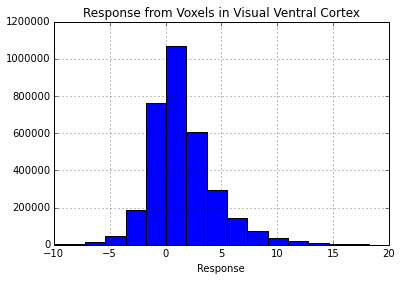

In [12]:
Brain['Response'].hist(bins=50)
plt.xlim(-10,20)
plt.title('Response from Voxels in Visual Ventral Cortex')
plt.xlabel('Response')

It was to be expected that the histogram would be skewed to the right.  As voxels respond to the experiment stimuli, they pull the distribution right. 

It is interesting that there are negative responses.  Since I switched the sign of the response earlier, brain activation is characterized by a positive value.  Therefore, I assume that a negative response value indicated deactiviation of a voxel in response to a stimulus.  Could this be a result of blood flowing away from certain voxels and towards others?  Such questions are beyond the scope of this project.
 

Now I will check if there is a distinguishable difference in the responses split by Image Type. 

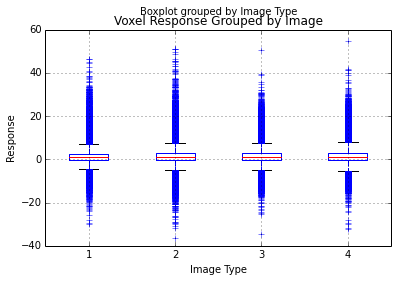

In [91]:
sub_df = Brain.boxplot(column='Response', by='Image Type')
plt.title('Voxel Response Grouped by Image')
plt.ylabel('Response')
plt.xlabel('Image Type')

These are very similar looking, with about the same mean value just above zero.

The next thing that I would like to explore is whether voxels tend to respond similarly across the 24 runs of the experiment. 

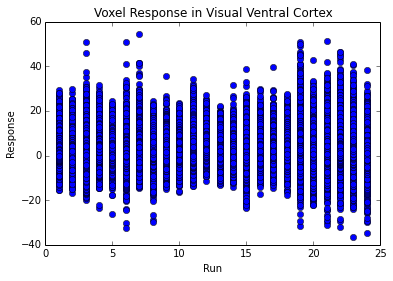

In [14]:
plt.plot(Brain.Run, Brain.Response, 'o')
plt.title('Voxel Response in Visual Ventral Cortex')
plt.ylabel('Response')
plt.xlabel('Run')

In [120]:
sub_df1 = Brain[Brain['Image Type']==2]
sub_df2 = Brain[Brain['Image Type']==3]

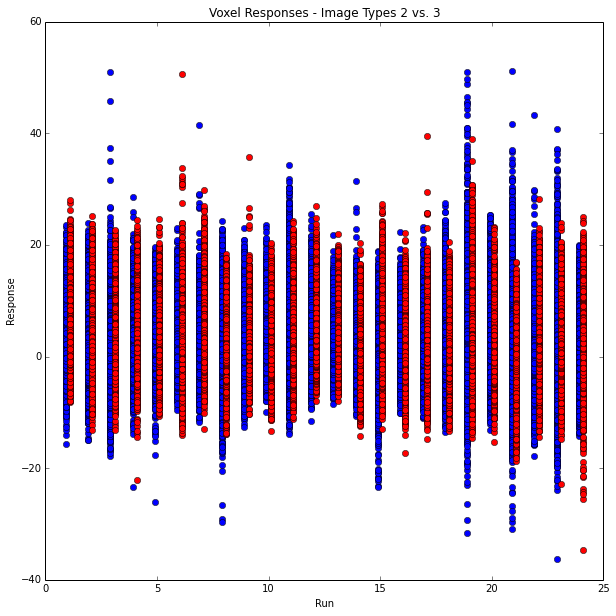

In [121]:
plt.figure(figsize=(10,10))
plt.plot(sub_df1.Run-0.1, sub_df1.Response, 'o', color = "blue")
plt.plot(sub_df2.Run+0.1, sub_df2.Response, 'o', color = "red")
plt.title('Voxel Responses - Image Types 2 vs. 3')
plt.ylabel('Response')
plt.xlabel('Run')
plt.show()

There is certainly a fair amount of variation between each run.  Now the question becomes: Are individual voxels behaving similarly across runs?  Are the voxels with the greatest response in one run the same as the voxels with the greatest response in another run?  I will test this by figuring out which voxels responded the most and then see how those voxels responded accross all of the runs.

I will start by looking at the voxel with the highest response (54.6) and seeing if it shows a consistent response across runs for individual image types.  Then I will look at some of the other mid-high responders that come in around 25.

In [97]:
max_response = Brain['Response'].max()
max_row = Brain[Brain['Response']==max_response]
mid_high_rows = Brain[(Brain['Response']>=24.9) & (Brain['Response']<=25.1)]

17.772185101064821

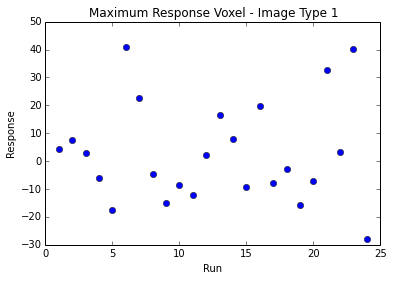

In [110]:
max_row = row.reset_index(drop=True)
max_voxel = row.ix[0,0]
sub_df = Brain[(Brain['Voxel']==max_voxel) & (Brain['Image Type']==1)]
plt.plot(sub_df.Run, sub_df.Response, 'o')
plt.title('Maximum Response Voxel - Image Type 1')
plt.ylabel('Response')
plt.xlabel('Run')
np.std(sub_df.Response)

This is not consistent at all! The standard deviation of the responses is over 17.7!

Let's see if this voxel responds more consistently for a different Image Type

20.826676872541512

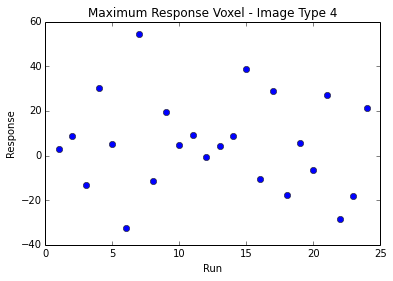

In [111]:
sub_df = Brain[(Brain['Voxel']==max_voxel) & (Brain['Image Type']==4)]
plt.plot(sub_df.Run, sub_df.Response, 'o')
plt.title('Maximum Response Voxel - Image Type 4')
plt.ylabel('Response')
plt.xlabel('Run')
np.std(sub_df.Response)

With this image type, we can see that the maximum response value (54.6) is present.  However, we still have no consistency across runs. This is troubling because it indicates that the linear regression did not effectively filter out noise.  Either that, or this voxel is responding to the stimulus in a different way during every run, which seems improbable.  Could this particular voxel be an outlier?  

Let's check some of the mid-high response voxels to see if they are any more consistent.  Let's first look at the rows that contain these mid-high response values (about 25).

In [98]:
mid_high_rows

,Voxel,i,j,k,Run,Image Type,Response
305761,5421,18,56,26,3,2,25.013
357646,14068,22,56,34,3,4,25.085
374206,16828,27,60,37,3,4,25.052
374302,16844,28,61,37,3,4,24.997
518834,18163,27,59,39,4,2,25.066
846958,4540,18,55,25,7,4,24.918
1125624,5445,20,57,26,9,3,25.020
1474995,18133,26,57,39,11,2,25.023
1485603,19901,26,56,42,11,2,24.966
1945340,5444,19,57,26,15,4,24.972


Voxels 16844 and 16828 both appear on the list more than once, so maybe they indicate the presense of voxels that respond consistently.  Let's plot their signals across all runs for each image type and see if there is any consistency.

6.8201428659265906

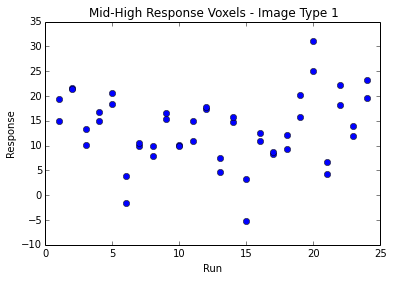

In [109]:
sub_df = Brain[((Brain['Voxel']==16844)|(Brain['Voxel']==16828)) & (Brain['Image Type']==1)]
plt.plot(sub_df.Run, sub_df.Response, 'o')
plt.title('Mid-High Response Voxels - Image Type 1')
plt.ylabel('Response')
plt.xlabel('Run')
np.std(sub_df.Response)

8.6272750371283564

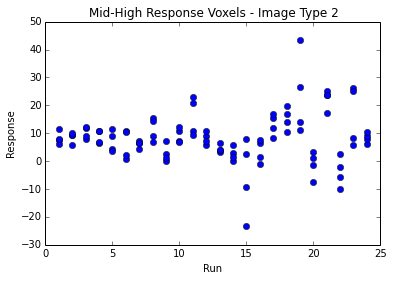

In [112]:
sub_df = Brain[((Brain['Voxel']==16844)|(Brain['Voxel']==16828)) & (Brain['Image Type']==2)]
plt.plot(sub_df.Run, sub_df.Response, 'o')
plt.title('Mid-High Response Voxels - Image Type 2')
plt.ylabel('Response')
plt.xlabel('Run')
np.std(sub_df.Response)

5.870431826907649

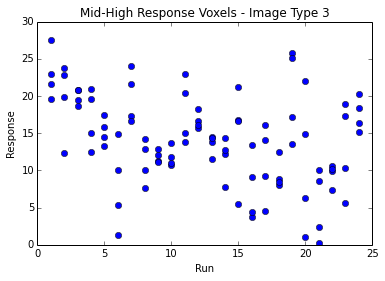

In [113]:
sub_df = Brain[((Brain['Voxel']==16844)|(Brain['Voxel']==16828)) & (Brain['Image Type']==3)]
plt.plot(sub_df.Run, sub_df.Response, 'o')
plt.title('Mid-High Response Voxels - Image Type 3')
plt.ylabel('Response')
plt.xlabel('Run')
np.std(sub_df.Response)

6.099833443295009

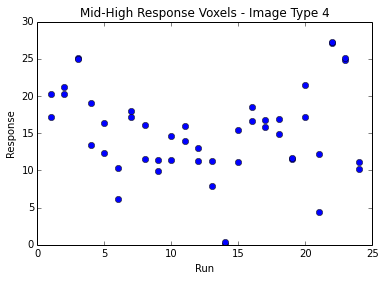

In [114]:
sub_df = Brain[((Brain['Voxel']==16844)|(Brain['Voxel']==16828)) & (Brain['Image Type']==4)]
plt.plot(sub_df.Run, sub_df.Response, 'o')
plt.title('Mid-High Response Voxels - Image Type 4')
plt.ylabel('Response')
plt.xlabel('Run')
np.std(sub_df.Response)

While image type 2 appears to show some level of consistency, this is only because the graph has a far larger response range.  However, it is interesting that for image 2, the data is more consistent during the first 19 runs. 

The standard deviations are howevering around 6.  This is vastly improved over the first voxel I tested, but it is still higher than I had hoped.  This could make pattern detection difficult!
I originally hoped that I could use voxels with high response values as the input to a machine learning classifier.  I hypothesized that high responses voxels would be good candidates to include in classifier training and test sets. However, if voxels with high signal values cannot be trusted to show consistency, then they may not create a great classifier.


## Classifier Voxel Selection

I come to one of my biggest challenges.  I would like to use machine learning to create a classifier that can predict an image type based on the responses of the voxels in the brain.  This is especially challenging because every voxel could potentially be a feature in the classifier, and there are 22,000 voxels to choose from!  I have a total of 24 runs X 6 Images = 144 data points to be used in the classification.  And there are 4 different classes that the classifier must choose from, meaning that I have between 24 and 48 data points per class.  It is difficult to find a classifier that can handle 144 data points and 22,000 features.  I must somehow decide which of the voxels to include as features for my classifier, and which to leave out.  

At my lab, the principle investigator was able to create a fairly successful classifier by feeding it 400 voxels from a special region of the brain that is well known to differentiate effectively between image types.  In a sense, they knew upfront which voxels were best to use.  I am attempting to select the voxels on my own, which is a far greater challenge.  Later on in this project, I will use these preselected voxels and see how well they perform in a classifier, and compare these results with those my self-chosen voxels.

When selecting voxels, I will have to keep in mind that simply choosing the voxels with the highest responses may not work because these voxels do not show great consistency in any one image category.  Let's see how it goes.

## Machine Learning: Classification

Keeping in mind that I have limited data points to work with, I will try two approaches to selecting voxels.  I will first try selecting voxels randomly, and then I will try selecting the voxels with the highest responses.

I will attempt to use the following Classifiers
1. K-Nearest Neighbors
2. Decision Trees
3. Support Vector Machines

The first step is to create an "X" dataframe (containing one datapoint per row) and a "Y" dataframe (containing classifications for the datapoints in the X dataframe).

In [156]:
# The following is the code that I attempted to run to create X.  However, it never seems that looping through a massive structure
# in Python is simply inefficient because the code never stops running.  

#X = np.zeros((96,Brain.Voxel.max()))
#for r in range(24):
#    for i in range(4):
#        for v in range(Brain.Voxel.max()):
#            X[(r+i*24),v] = Brain[(Brain['Voxel']==(v+1)) & (Brain['Run']==(r+1)) & (Brain['Image Type']==(i+1))].iloc[0,6]


Since Python is having trouble creating such a large dataframe, I have decided to create a second dataframe in Matlab that I will use to create my X and Y dataframes.  Matlab can handle the looping process required to generate a dataframe much better than Python.  Again I will use Matlab to write the dataframe to a CSV file.

Update: Creating the dataframe in Matlab was a success.

In [16]:
DFXY = pd.read_csv('ClassifierDataframe.csv', header=None) 
#This is the dataframe for the classifier.  Each row is a datapoint and contains one column to hold the class (or image type) 
# that corresponds to that row.  There is also a column to hold the run number.  Then, starting with column 3, there is a column 
# to hold the signal value for every voxel. Therefore, the dataframe has about 144 rowns and over 22,000 columns!
DFXY.shape  #The new dataframe has the expected dimensions.  144 rows equate to 24 runs X 6 images.

(144, 22772)

In [17]:
DFXY.head()  #Let's see what this new dataframe looks like

,0,1,2,3,4,5,6,7,8,9,...,22762,22763,22764,22765,22766,22767,22768,22769,22770,22771
0,4,1,-2.92800,0.002527,-3.1290,-1.9352,-3.1985,1.29890,1.73750,3.05380,...,0.28710,-0.81367,-2.4556,-6.8367,-5.23560,-0.22837,-1.9864,-3.4128,-2.99800,-2.26420
1,1,2,-0.24731,-3.276100,-1.3408,1.1147,-1.8475,2.07960,1.59270,1.17750,...,-0.58235,-2.89910,-2.9117,-2.8124,-2.88520,-1.93720,-2.2146,-2.8661,-2.98880,-1.93000
2,3,3,-0.28672,-4.238600,-2.8976,-1.5531,-2.2761,-1.20160,-1.75020,-0.86410,...,0.31839,-0.79139,-3.3501,-4.0150,-0.59241,0.91796,-1.1531,-2.4369,1.31820,2.93740
3,2,4,-2.06070,1.007300,-2.9160,-0.1900,2.3234,-0.58522,0.44826,0.12427,...,-0.23930,-3.24740,-4.2699,-4.8017,-2.73050,-1.79700,-3.2432,-4.0890,-0.54044,0.68093
4,4,5,-2.75230,-1.388900,-3.0094,-1.6627,-1.6674,-0.70358,-1.61980,-1.67660,...,-1.46050,-2.14070,-2.5889,-3.1906,-1.82980,-2.53610,-2.8794,-3.6598,-1.56610,0.10786


In [110]:
#Now to create separate X and Y dataframes to be fed to a classifier

X = DFXY.ix[:,2:].values  #This is all of the response values for all of the voxels
X = pd.DataFrame(X)
Y = DFXY.ix[:,0]   #This lists the class for each row
X.head()

,0,1,2,3,4,5,6,7,8,9,...,22760,22761,22762,22763,22764,22765,22766,22767,22768,22769
0,-2.92800,0.002527,-3.1290,-1.9352,-3.1985,1.29890,1.73750,3.05380,3.8254,2.253600,...,0.28710,-0.81367,-2.4556,-6.8367,-5.23560,-0.22837,-1.9864,-3.4128,-2.99800,-2.26420
1,-0.24731,-3.276100,-1.3408,1.1147,-1.8475,2.07960,1.59270,1.17750,-3.5019,-3.754400,...,-0.58235,-2.89910,-2.9117,-2.8124,-2.88520,-1.93720,-2.2146,-2.8661,-2.98880,-1.93000
2,-0.28672,-4.238600,-2.8976,-1.5531,-2.2761,-1.20160,-1.75020,-0.86410,-2.7281,-3.336000,...,0.31839,-0.79139,-3.3501,-4.0150,-0.59241,0.91796,-1.1531,-2.4369,1.31820,2.93740
3,-2.06070,1.007300,-2.9160,-0.1900,2.3234,-0.58522,0.44826,0.12427,-2.5716,-0.744890,...,-0.23930,-3.24740,-4.2699,-4.8017,-2.73050,-1.79700,-3.2432,-4.0890,-0.54044,0.68093
4,-2.75230,-1.388900,-3.0094,-1.6627,-1.6674,-0.70358,-1.61980,-1.67660,-1.5947,-0.062457,...,-1.46050,-2.14070,-2.5889,-3.1906,-1.82980,-2.53610,-2.8794,-3.6598,-1.56610,0.10786


In [42]:
# Let's Try a K-Nearest Neighbor Classifier and a Random Sampling of Voxels
# First get a random sample

rand_voxels = random.sample(range(X.shape[1]), 10)
X_random_10 = X.ix[:,rand_voxels]
X_random_10.shape #Confirm that we have the correct number or columns for 10 voxels

(144, 10)

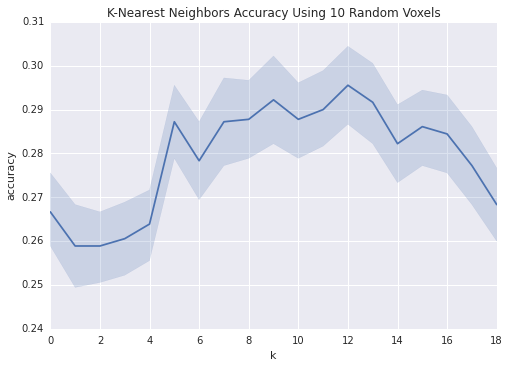

In [50]:
#K-Nearest Neighbor Classification Using 10 Randomly Chosen Voxels

k_values = range(1,20)
random_seeds = np.random.randint(1000, size=50)

def accuracy_for_k_val2(k,x_train, x_val, y_train, y_val):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, weights = 'uniform')
    knn.fit(x_train,y_train)
    y_hat = knn.predict(x_val)
    return sklearn.metrics.accuracy_score(y_val, y_hat, normalize=True)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_10, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using 10 Random Voxels')
plt.show()

The accuracy using 10 random voxels seems to max out at about 30%.  These results are barely better than if the classifier were randomly choosing classes (which would give an expected 25% accuracy since there are 4 classes).  From this plot, it can be seen that a using between 9 and 12 neighbors gives the best results.  Let's see if these results are consistent by rerunning the code.

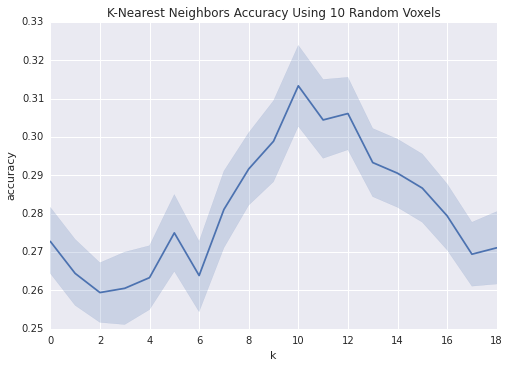

In [62]:
#K-Nearest Neighbor Classification Using 10 Randomly Chosen Voxels - AGAIN

k_values = range(1,20)
random_seeds = np.random.randint(1000, size=50)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_10, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using 10 Random Voxels')
plt.show()

Again, at about the 10 neighbors point, the accuracy peaks at only about 30%.  Let's see if varying the number of voxels changes the results.

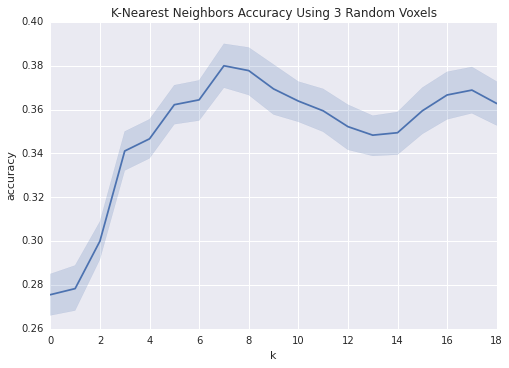

In [57]:
#K-Nearest Neighbor Classification Using 3 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 3)
X_random_3 = X.ix[:,rand_voxels]

k_values = range(1,20)
random_seeds = np.random.randint(1000, size=50)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_3, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using 3 Random Voxels')
plt.show()

The max accuracy using 3 voxels is approaching 40%, a vast improvement over 10 voxels.  This may be because 10 voxels is too many features to use given the limited number of data points.  However, the improved results may be because we stumbled upon a voxel that is a good predictor.  Let see if this accuracy scoring is repeatable.

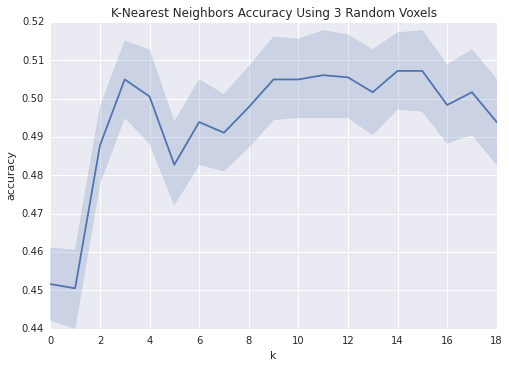

In [58]:
# K-Nearest Neighbor Classification Using 3 Randomly Chosen Voxels - AGAIN

rand_voxels = random.sample(range(X.shape[1]), 3)
X_random_3 = X.ix[:,rand_voxels]

k_values = range(1,20)
random_seeds = np.random.randint(1000, size=50)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_3, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using 3 Random Voxels')
plt.show()

Wow, running this code again, we can crack the 50% mark!  However, I reran this code a few times, and I also got results as low as 30%.  It seems totally dependent on whether an informative voxel was chosen.

Now let's confirm that going up to 20 voxels is a bad idea

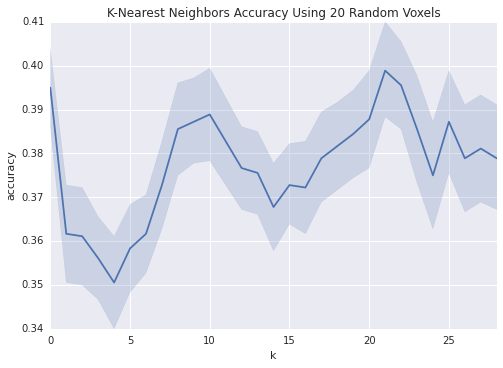

In [61]:
# K-Nearest Neighbor Classification Using 20 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 20)
X_random_20 = X.ix[:,rand_voxels]

k_values = range(1,30)
random_seeds = np.random.randint(1000, size=50)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_20, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using 20 Random Voxels')
plt.show()

Running this code multiple times, the accuracy results range from a low of 30% to a high of 45%, always peaking at 20 neighbors.  Curiously, it seems that using 10 voxels has a lower accuracy than 3 or 20 voxels.  Let's see what happens if we use a very high number of voxels.

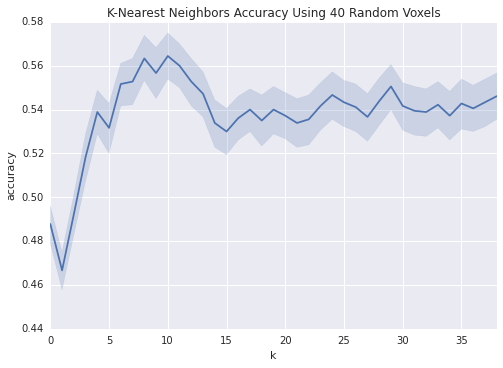

In [65]:
# K-Nearest Neighbor Classification Using 40 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 40)
X_random_40 = X.ix[:,rand_voxels]

k_values = range(1,40)
random_seeds = np.random.randint(1000, size=50)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_40, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using 40 Random Voxels')
plt.show()

Rerunning this code gives consistently good results between 40 and 60%!  This answers the question of whether 10 voxels was too much for a nearest neighbors classifier.  The answer is no!  Let's keep going up.

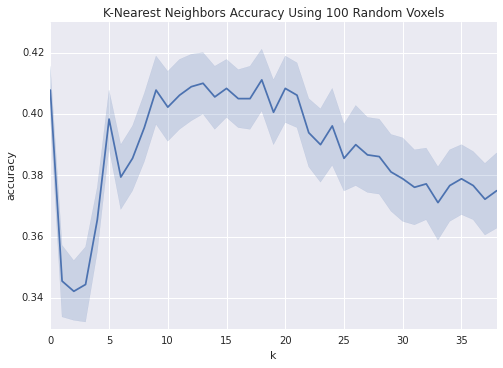

In [68]:
# K-Nearest Neighbor Classification Using 100 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 100)
X_random_100 = X.ix[:,rand_voxels]

k_values = range(1,40)
random_seeds = np.random.randint(1000, size=50)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_100, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using 100 Random Voxels')
plt.show()

There is no marked improvement in accuracy.  Repeating this test, we remain in the 40 to 60% accuracy range.  It would appear that even through we are giving the classifier more information, it no longer seems to help with the classification accuracy.  This may be a limitation in the number of features that the nearest neighbors classifier take advantage of.  Or it could be a limitation in the possible prediction accuracy using fMRI data.  

Let's try using a different method for selecting voxels.  Let's try using those with the highest response values.  Since the nearest neighbors classifier stop improving after 40, let's take the top 40 voxels.

In [114]:
response_sum = X.sum(axis=0) 
X_highest_40 = X.ix[:,response_sum>131] # I arrived at the number 131 through trail and error.  This happens to give me 40 voxels.
X_highest_40.head()

,37,38,96,104,106,107,108,109,120,121,...,14184,14841,15150,15170,15188,20392,22152,22413,22421,22432
0,-3.89260,-5.2751,6.157600,-0.18190,4.51620,3.427000,-0.094214,-2.19570,1.27570,0.24201,...,-0.96198,2.67330,0.53928,0.67366,-2.268400,0.49839,6.2579,-2.64920,0.35132,3.2423
1,-6.22790,-7.4455,0.019373,-3.19570,2.37310,1.071800,-1.474400,-1.79030,-3.08280,-4.55140,...,1.97520,-0.54552,-1.13590,1.06600,1.703200,0.31329,2.8867,-0.48423,0.41402,1.9684
2,0.21727,-2.8376,1.760600,-0.95125,0.64549,1.039200,-0.196000,-2.24340,-0.52475,-1.16480,...,1.03830,-3.00460,2.16380,3.48610,-0.920980,6.24540,7.1406,2.30170,5.90560,8.3933
3,-2.24570,-4.4432,1.917600,0.75472,0.57392,-0.017641,-0.008671,-0.72225,-0.55911,1.65150,...,0.11557,-1.41380,-1.60350,1.44130,0.000884,3.14080,4.7199,-1.51350,-5.51560,5.6963
4,-3.31670,-1.4152,1.319400,-0.95894,-0.77206,-0.377580,-1.906000,-2.94640,-0.54745,-1.11350,...,1.43400,2.67680,0.83757,1.36870,0.491860,1.17970,1.4656,0.58161,2.02030,2.5425


Now let's repeat the nearest neighbors classifier using these 40 highest sum voxels.

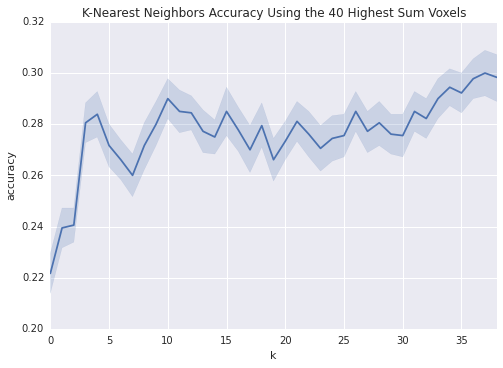

In [115]:
# K-Nearest Neighbor Classification Using the 40 Highest Sum Voxels

k_values = range(1,40)
random_seeds = np.random.randint(1000, size=50)

values = np.zeros((len(k_values),random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_highest_40, Y, test_size=0.25, random_state=rs)
    for k, c_k in zip(k_values, range(len(k_values))):
        value = accuracy_for_k_val2(k=k,x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
        values[c_k,c_rs] = value

sns.tsplot(values.T)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('K-Nearest Neighbors Accuracy Using the 40 Highest Sum Voxels')
plt.show()

The accuracy hovers between 25% and 30%.  As I feared, these voxels are not reliable predictors of image type, at least not using a nearest neighbors classifier.

## Decision Tree Classifier

Let's see how a decision tree classifier fairs.  Let's start using 10 randomly selected voxels.

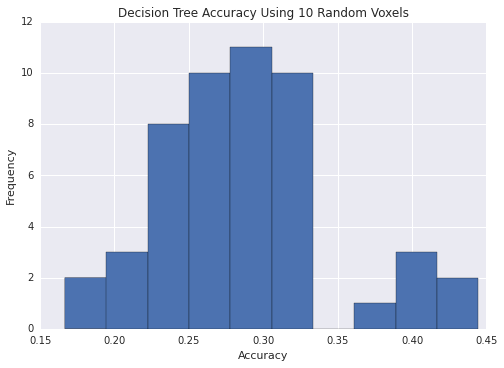

0    0.278333
dtype: float64

In [141]:
# Decision Tree Classification Using 10 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 10)
X_random_100 = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

def accuracy_for_d_tree(x_train, x_val, y_train, y_val):
    decisionTree = sklearn.tree.DecisionTreeClassifier()
    decisionTree.fit(x_train, y_train)
    y_hat = decisionTree.predict(x_val)
    return sklearn.metrics.accuracy_score(y_val, y_hat, normalize=True)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random_10, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Decision Tree Accuracy Using 10 Random Voxels')
plt.show()
values.mean()

The mean accuracy using 10 voxels is only about 27%.  Let's try some other values.

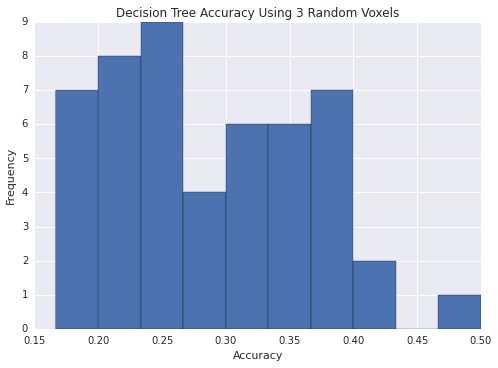

0    0.291111
dtype: float64

In [142]:
# Decision Tree Classification Using 3 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 3)
X_random = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Decision Tree Accuracy Using 3 Random Voxels')
plt.show()
values.mean()

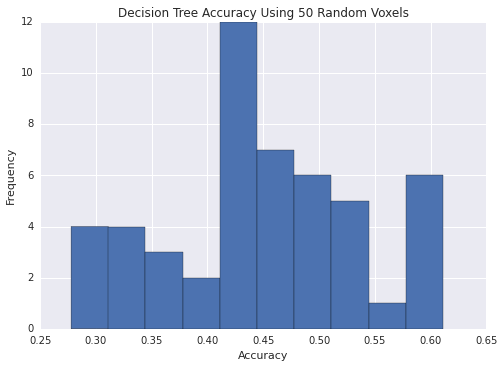

0    0.453333
dtype: float64

In [149]:
# Decision Tree Classification Using 50 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 50)
X_random = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Decision Tree Accuracy Using 50 Random Voxels')
plt.show()
values.mean()

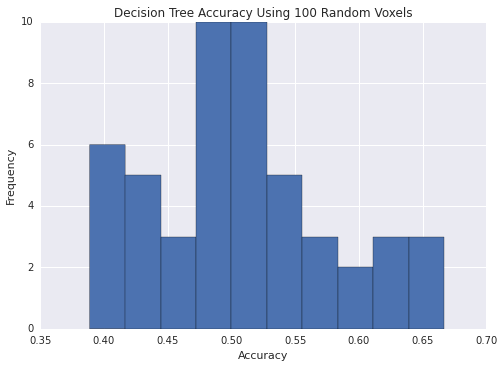

0    0.494444
dtype: float64

In [150]:
# Decision Tree Classification Using 100 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 100)
X_random = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Decision Tree Accuracy Using 100 Random Voxels')
plt.show()
values.mean()

Once again, using 10 voxels seems to give the poorest results.  Using both 3 voxels, the accuracy rises to nearly 30%.  However, using 50, the accuracy rises to around 50%!  Nothing seems to be gained by going above 50.  We have again hit a cap of about 50%.

## Support Vector Machines

Support vectors machines could be the greatest hope for this endevor, as they can better handle a high dimensionality feature space.  Let's see what happens.

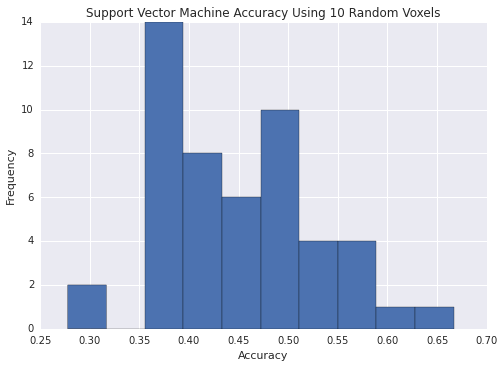

0    0.448333
dtype: float64

In [152]:
svm.SVC()
# Support Vector Machine Classification Using 10 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 10)
X_random = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

def accuracy_for_svm(x_train, x_val, y_train, y_val):
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_val)
    return sklearn.metrics.accuracy_score(y_val, y_hat, normalize=True)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Support Vector Machine Accuracy Using 10 Random Voxels')
plt.show()
values.mean()

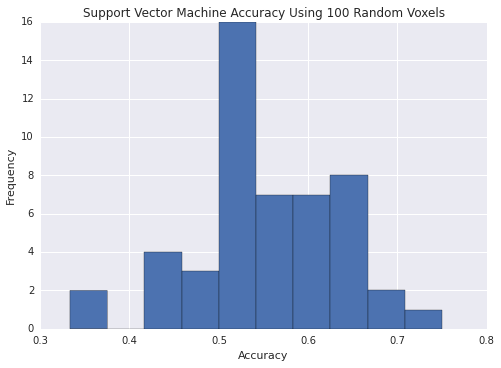

0    0.552222
dtype: float64

In [153]:
svm.SVC()
# Support Vector Machine Classification Using 100 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 100)
X_random = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

def accuracy_for_svm(x_train, x_val, y_train, y_val):
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_val)
    return sklearn.metrics.accuracy_score(y_val, y_hat, normalize=True)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Support Vector Machine Accuracy Using 100 Random Voxels')
plt.show()
values.mean()

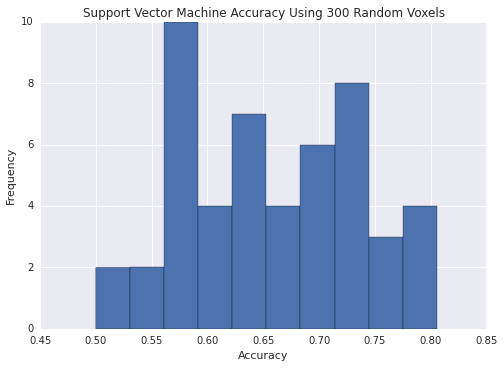

0    0.657778
dtype: float64

In [154]:
svm.SVC()
# Support Vector Machine Classification Using 300 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 300)
X_random = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

def accuracy_for_svm(x_train, x_val, y_train, y_val):
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_val)
    return sklearn.metrics.accuracy_score(y_val, y_hat, normalize=True)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Support Vector Machine Accuracy Using 300 Random Voxels')
plt.show()
values.mean()

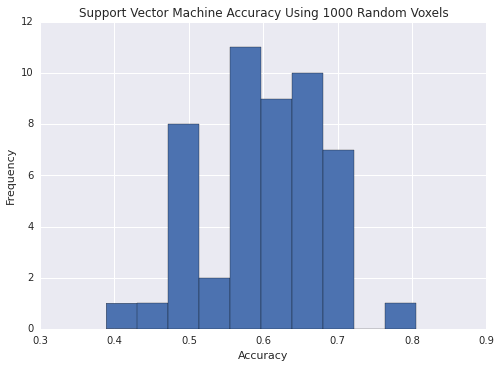

0    0.595
dtype: float64

In [155]:
svm.SVC()
# Support Vector Machine Classification Using 1000 Randomly Chosen Voxels

rand_voxels = random.sample(range(X.shape[1]), 1000)
X_random = X.ix[:,rand_voxels]

random_seeds = np.random.randint(1000, size=50)

def accuracy_for_svm(x_train, x_val, y_train, y_val):
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    y_hat = clf.predict(x_val)
    return sklearn.metrics.accuracy_score(y_val, y_hat, normalize=True)

values = np.zeros((random_seeds.shape[0]))
for rs,c_rs in zip(random_seeds, range(random_seeds.shape[0])):
    x_train, x_val, y_train, y_val = sklearn.cross_validation.train_test_split(
                        X_random, Y, test_size=0.25, random_state=rs)
    value = accuracy_for_d_tree(x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
    values[c_rs] = value

values = pd.DataFrame(values)
values.hist(bins = 10)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Support Vector Machine Accuracy Using 1000 Random Voxels')
plt.show()
values.mean()

As expected, the support vector machine provides the highest accuracy score, passing by 50% and maxing out around 65%.  This is because of its ability to work effectively in a high dimensionality feature space.  By passing the SVM more voxels, we are providing it with more potentially important features.  In other words, by giving it more voxels, there is a high probability that some "informative" voxels will make it into the classifier.  This rise in accuracy continues through 300 voxels.  However, going up to 1000 voxels was to much for even an SVM.

## Final Analysis
It seems that fMRI data can in fact be used to acheive moderate prediction accuracy of over 50%.  My suspicion that a support vector machine would be the most effective tool was confirmed when I reached accuracy scores of around 65%. 

I was not able to acheive my initial goal of a 90% prediction rate.  I based my selection of this threshold on the knowledge that my lab was acheiving scores above 90%.  However, I had not understood that the lab was utilizing a preselected set of the most informative voxels (a set of voxels in the PIT region of the brain that is often used by neuroscientists for such purposes).  I did not want to use this set of voxels because doing do felt uninteresting, almost like cheating.  Therefore, I used the entire visual ventral stream and did my best.  I feel that my results are respectable given that I did not have the advantage of preselected voxels.

It would appear that using only small highly informative regions of the brain for machine learning (as my lab did) does result in better results than trying to use voxels that are sampled from a larger region of the brain.